# Sentence Transformer

In [1]:
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk
from transformers import DebertaV2Tokenizer, DebertaV2Model

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

## GPU

In [2]:
!nvidia-smi

Sun Oct  1 13:41:42 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  | 00000000:01:00.0  On |                  N/A |
| 27%   40C    P8              11W / 151W |   1282MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyperparameters

In [4]:
# Hyperparameters
LEARNING_RATE = 0.000005
BATCH_SIZE = 24
EPOCHS = 200

## Path

## Generate dataset and batch

In [5]:
class PromptDataset(Dataset):

    def __init__(self, dataset, device):
        self.dataset = dataset
        self.device = device

    def deserialize_array(self, binary_string, dtype, shape):
        return np.frombuffer(binary_string, dtype=dtype).reshape(shape)

    def __getitem__(self, index):
        data = self.dataset[index]
        # retrieve values
        student_id = data['student_id']
        prompt_id = data['prompt_id']
        sentence = data['sentence']
        t_q_a_embeddings = torch.tensor(self.deserialize_array(data['t_q_a_embeddings'], np.float32, (768,))).to(self.device)
        embeddings_text = torch.tensor(self.deserialize_array(data['embeddings_text'], np.float32, (768,))).to(self.device)
        content = torch.tensor(data['content']).to(self.device)
        wording = torch.tensor(data['wording']).to(self.device)
        normalized_lexical_density = torch.tensor(data['normalized_lexical_density']).unsqueeze(0).to(self.device)
        normalized_spell_checker = torch.tensor(data['normalized_spell_checker']).unsqueeze(0).to(self.device)
        normalized_tf_idf_question_score = torch.tensor(data['normalized_tf_idf_question_score']).unsqueeze(0).to(self.device)
        normalized_avg_word_length = torch.tensor(data['normalized_avg_word_length']).unsqueeze(0).to(self.device)
        normalized_smog_index = torch.tensor(data['normalized_smog_index']).unsqueeze(0).to(self.device)
        normalized_coleman_liau_index = torch.tensor(data['normalized_coleman_liau_index']).unsqueeze(0).to(self.device)
        normalized_flesch_reading_ease = torch.tensor(data['normalized_flesch_reading_ease']).unsqueeze(0).to(self.device)
        
        return {
            'student_id': student_id,
            'prompt_id': prompt_id,
            'sentence': sentence,
            't_q_a_embeddings': t_q_a_embeddings,
            'embeddings_text': embeddings_text,
            'content': content,
            'wording': wording,
            'normalized_lexical_density': normalized_lexical_density,
            'normalized_spell_checker': normalized_spell_checker,
            'normalized_tf_idf_question_score': normalized_tf_idf_question_score,
            'normalized_avg_word_length': normalized_avg_word_length,
            'normalized_smog_index': normalized_smog_index,
            'normalized_coleman_liau_index': normalized_coleman_liau_index,
            'normalized_flesch_reading_ease': normalized_flesch_reading_ease,
        }

    def __len__(self) -> int :
        return self.dataset.num_rows

In [6]:
class DataLoaderFactory():

    def __init__(self, path:str = './data/hugging_face', batch_size = 12, device = 'cpu'):
        self.batch_size = batch_size
        self.dataset = load_from_disk(path, keep_in_memory=True)
        self.device = device

        print("1. Loading dataset: ...", end="")
        dataset = load_from_disk(path, keep_in_memory=True)
        print("\r1. Loading dataset: done ✔️")

        print("2. Split datasets: ...", end="")
        train_validation_splits = self.dataset['train'].train_test_split(test_size=0.3)
        validation_test_splits = train_validation_splits['test'].train_test_split(test_size=0.4)
        print("\r2. Preprocess datasets: done ✔️")

        print("3. Split datasets: ...", end="")
        self.train_data = PromptDataset(train_validation_splits['train'], self.device)
        self.val_data = PromptDataset(validation_test_splits['train'], self.device)
        self.test_data = PromptDataset(validation_test_splits['test'], self.device)
        print("\r3. Split datasets: done ✔️")

        self.dataloader_train = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.dataloader_val = DataLoader(self.val_data, batch_size=batch_size, shuffle=True)
        self.dataloader_test = DataLoader(self.test_data, batch_size=batch_size, shuffle=True)
    
    
    def __len__(self) -> int :
        print("\033[95m\033[1m\033[4mNumber of data by datasets splits\033[0m")
        print(f"Train\t\t: {len(self.train_data)}\t-> {len(self.train_data)/self.batch_size}")
        print(f"Validation\t: {len(self.val_data)}\t\t-> {len(self.val_data)/self.batch_size}")
        print(f"Test\t\t: {len(self.test_data)}\t\t-> {len(self.test_data)/self.batch_size}")
        total = len(self.train_data) + len(self.val_data)
        print(f"Total\t\t: {total}")
        return total

    def get_batch(self, split):
        # choose the correct dataloader
        if split == 'train':
            dataloader = self.dataloader_train
        elif split == 'val':
            dataloader = self.dataloader_val
        else:
            dataloader = self.dataloader_test

        for batch in dataloader:
            # Move tensors to device
            batch_on_device = {k: v for k, v in batch.items()}
            yield batch_on_device

### Load the dataset

In [7]:
dataset = DataLoaderFactory(device=device, batch_size=BATCH_SIZE)
len(dataset)

1. Loading dataset: done ✔️
2. Preprocess datasets: done ✔️
3. Split datasets: done ✔️
Number of data by datasets splits
Train		: 5015	-> 208.95833333333334
Validation	: 1290		-> 53.75
Test		: 860		-> 35.833333333333336
Total		: 6305


6305

### Testing the dataset

In [8]:
batch = dataset.get_batch('train')
nb = next(batch)

In [9]:
print(f"{'student_id:':<25}{len(nb['student_id'])}")
print(f"{'prompt_id:':<25}{len(nb['prompt_id'])}")
print(f"{'sentence:':<25}{len(nb['sentence'])}")
print(f"{'t_q_a_embeddings:':<25}{nb['t_q_a_embeddings'].shape}")
print(f"{'embeddings_text:':<25}{nb['embeddings_text'].shape}")
print(f"{'content:':<25}{nb['content'].shape}")
print(f"{'wording:':<25}{nb['wording'].shape}")
print(f"{'normalized_lexical_density:':<25}{nb['normalized_lexical_density'].shape}")
print(f"{'normalized_spell_checker:':<25}{nb['normalized_spell_checker'].shape}")
print(f"{'normalized_tf_idf_question_score:':<25}{nb['normalized_tf_idf_question_score'].shape}")
print(f"{'normalized_avg_word_length:':<25}{nb['normalized_avg_word_length'].shape}")
print(f"{'normalized_smog_index:':<25}{nb['normalized_smog_index'].shape}")
print(f"{'normalized_coleman_liau_index:':<25}{nb['normalized_coleman_liau_index'].shape}")
print(f"{'normalized_flesch_reading_ease:':<25}{nb['normalized_flesch_reading_ease'].shape}")

student_id:              24
prompt_id:               24
sentence:                24
t_q_a_embeddings:        torch.Size([24, 768])
embeddings_text:         torch.Size([24, 768])
content:                 torch.Size([24])
wording:                 torch.Size([24])
normalized_lexical_density:torch.Size([24, 1])
normalized_spell_checker:torch.Size([24, 1])
normalized_tf_idf_question_score:torch.Size([24, 1])
normalized_avg_word_length:torch.Size([24, 1])
normalized_smog_index:   torch.Size([24, 1])
normalized_coleman_liau_index:torch.Size([24, 1])
normalized_flesch_reading_ease:torch.Size([24, 1])


## Training model

1. **Input Layer:** Accept the embeddings of the question, text, and answer. This would result in three separate input layers, each of dimension `[batch_size, embedding_size]`.
2. **Concatenate Layer:** Concatenate the embeddings along the feature axis. This results in `[batch_size, 3 * embedding_size]` dimensions.
3. **Dense Layers:** Add a couple of Dense layers with suitable dropout layers in between for regularization. For instance:
    - Dense layer with `1024` units, `ReLU` activation.
    - Dropout layer with rate `0.5`.
    - Dense layer with `512` units, ReLU activation.
    - Another Dropout layer with rate `0.5`.
4. **Output Layer:** Single Dense layer with `2` units (since you want two values between -1 and 1) and a `tanh` activation function.
5. **Loss Function:** If the output of your model is a vector with two values between -1 and 1, then you're essentially dealing with multi-output regression. You can use `Mean Squared Error` or `Mean Absolute Error`, but it'll be applied to each output.
6. **Optimizer:** Remains the same; options include `Adam`, `RMSprop`, and `SGD`.

## Utils

In [10]:
class DebertaV3Batch(torch.nn.Module):
    def __init__(self):
        super(DebertaV3Batch, self).__init__()
        # Load the tokenizer and model
        self.tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')
        self.model = DebertaV2Model.from_pretrained('microsoft/deberta-v3-base')
    

    def encode(self, sentences):
        # Tokenize sentences
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        # Compute token embeddings
        with torch.no_grad():
            model_output = self.model(**encoded_input)

        # Only take the embeddings of the [CLS] token (or use the mean of the token embeddings if desired)
        sentence_embeddings = model_output.last_hidden_state[:, 0, :]
        
        return sentence_embeddings

In [11]:
class DebertaV3(torch.nn.Module):
    def __init__(self):
        super(DebertaV3, self).__init__()
        # Load the tokenizer and model
        self.tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')
        self.model = DebertaV2Model.from_pretrained('microsoft/deberta-v3-base')


    def sliding_window(self, text, window_size=512, overlap_size=256):
        tokenized_text = self.tokenizer(text, return_tensors="pt", truncation=False, padding=False)["input_ids"][0]
        windows = []
        for start_idx in range(0, len(tokenized_text) - window_size + 1, window_size - overlap_size):
            end_idx = start_idx + window_size
            windows.append(tokenized_text[start_idx:end_idx])
        return windows

    def process_windows(self, windows):
        embeddings = []
        for window in windows:
            inputs = {"input_ids": window.unsqueeze(0)}
            outputs = self.model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding)
        return embeddings
    

    def encode(self, sentences):
        # Tokenize sentences
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        # Compute token embeddings
        with torch.no_grad():
            model_output = self.model(**encoded_input)

        if len(encoded_input['input_ids'][0]) > 512:
            windows = self.sliding_window(sentences)
            window_embeddings = self.process_windows(windows)
            
            # Optionally, you can aggregate the window embeddings to get a single embedding for the entire text
            # For example, by averaging:
            average_embedding = torch.mean(torch.cat(window_embeddings), dim=0)
            return average_embedding
        else:
            # Only take the embeddings of the [CLS] token (or use the mean of the token embeddings if desired)
            sentence_embeddings = model_output.last_hidden_state[:, 0, :]
            
            return sentence_embeddings[0]

In [12]:
deberta = DebertaV3()
debertaBatch = DebertaV3Batch()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Define the Model

In [13]:
# # Define the Model
# class QA_Score_Model(nn.Module):
#     def __init__(self, input_dim=3*768+7, dropout_rate=0.5):
#         super(QA_Score_Model, self).__init__()

#         # Dense Layers
#         self.fc1 = nn.Linear(input_dim, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 2)  # Output 2 values for each instance

#         # Dropout
#         self.dropout = nn.Dropout(dropout_rate)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         if self.training:
#             x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         if self.training:
#             x = self.dropout(x)
#         x = torch.tanh(self.fc3(x))  # tanh to get outputs in range [-1, 1]
#         return x

In [14]:
class QA_Score_Model(nn.Module):
    def __init__(self, embedding_dim, dropout_rate=0.5):
        super(QA_Score_Model, self).__init__()

        # Embedding processors
        self.fc_text = nn.Linear(embedding_dim, 256)
        self.fc_t_q_a = nn.Linear(embedding_dim, 256)

        # Scalar Processors
        self.fc_lexical = nn.Linear(1, 16)
        self.fc_spell = nn.Linear(1, 16)
        self.fc_tfidf = nn.Linear(1, 16)
        self.fc_avg_word_length = nn.Linear(1, 16)
        self.fc_smog = nn.Linear(1, 16)
        self.fc_coleman = nn.Linear(1, 16)
        self.fc_flesch = nn.Linear(1, 16)

        # Dropout layers
        self.dropout = nn.Dropout(dropout_rate)

        # Shared Dense Layers
        self.fc1 = nn.Linear(256*2 + 16*7, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # Output Layers
        self.out_content = nn.Linear(256, 1)
        self.out_wording = nn.Linear(256, 1)
        
    def forward(self, text, t_q_a, features):
        lexical, spell, tfidf, avg_word_length, smog, coleman, flesch = features
        # Pass through convolutional layers
        x_text = F.relu(self.fc_text(text))
        x_t_q_a = F.relu(self.fc_t_q_a(t_q_a))

        # Pass through scalar processors
        x_lexical = F.relu(self.fc_lexical(lexical))
        x_spell = F.relu(self.fc_spell(spell))
        x_tfidf = F.relu(self.fc_tfidf(tfidf))
        x_avg_word_length = F.relu(self.fc_avg_word_length(avg_word_length))
        x_smog = F.relu(self.fc_smog(smog))
        x_coleman = F.relu(self.fc_coleman(coleman))
        x_flesch = F.relu(self.fc_flesch(flesch))
        
        # Concatenate
        x = torch.cat((x_text, x_t_q_a, x_lexical, x_spell, x_tfidf, x_avg_word_length, x_smog, x_coleman, x_flesch), dim=1)
        
        # Pass through shared dense layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output
        content = self.out_content(x)
        wording = self.out_wording(x)
        
        return torch.cat((content, wording), dim=1).to(device)

### MCRMSE loss

In [15]:
class MCRMSELoss(nn.Module):
    def __init__(self):
        super(MCRMSELoss, self).__init__()

    def forward(self, y_true, y_pred):
        colwise_mse = torch.mean(torch.square(y_true - y_pred), dim=0)
        return torch.mean(torch.sqrt(colwise_mse), dim=0)

In [16]:
def MCRMSE(targets, predictions):
    """
    Compute the Mean Columnwise Root Mean Squared Error.
    
    Parameters:
    - targets: Actual target values
    - predictions: Model's predictions
    
    Returns:
    - Mean Columnwise RMSE
    """
    # Compute squared error
    mse = torch.mean((targets - predictions) ** 2, dim=0)
    
    # Take square root of each column's MSE
    rmse = torch.sqrt(mse)
    
    # Compute mean of RMSE across all columns
    mcrmse = torch.mean(rmse)
    
    return mcrmse

### Create an instance of the model, loss function and the optimizer

In [17]:
# Create an instance of the model, loss function and the optimizer
model = QA_Score_Model(768)
model = model.to(device)
criterion = MCRMSELoss()  # Mean Absolute Error less sensitive to outliers # MSELoss Mean Squared Error Loss
# criterion = nn.L1Loss()  # Mean Absolute Error less sensitive to outliers # MSELoss Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training loop

In [18]:
def training_loop(model, dataset, epoch):
    model = model.train()
    
    total_train_loss = 0.0
    # total_train_mcrmse = 0.0
    
    batchs = dataset.get_batch('train')
    
    num_train_batches = len(dataset.train_data) // BATCH_SIZE
    for i, batch in enumerate(batchs):
        # Get the batch data
        student_id = batch['student_id']
        prompt_id = batch['prompt_id']
        t_q_a_embeddings = batch['t_q_a_embeddings']
        embeddings_text = batch['embeddings_text']
        content = batch['content']
        wording = batch['wording']
        normalized_lexical_density = batch['normalized_lexical_density']
        normalized_spell_checker = batch['normalized_spell_checker']
        normalized_tf_idf_question_score = batch['normalized_tf_idf_question_score']
        normalized_avg_word_length = batch['normalized_avg_word_length']
        normalized_smog_index = batch['normalized_smog_index']
        normalized_coleman_liau_index = batch['normalized_coleman_liau_index']
        normalized_flesch_reading_ease = batch['normalized_flesch_reading_ease']
        
        # create input targets
        targets = torch.stack(
            (
                content,
                wording
            ), dim=1).to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        features = (normalized_lexical_density, \
                    normalized_spell_checker, \
                    normalized_tf_idf_question_score, \
                    normalized_avg_word_length, \
                    normalized_smog_index, \
                    normalized_coleman_liau_index, \
                    normalized_flesch_reading_ease \
                   )
        outputs = model(embeddings_text.to(device), t_q_a_embeddings.to(device), features)

        # Loss
        loss = criterion(targets, outputs)
        # eval_metric = MCRMSE(targets, outputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print loss (you might want to print every N batches, not every batch)
        print(f"\rEpoch [{epoch + 1}/{EPOCHS}], Batch [{i}/{num_train_batches}], Loss: {loss.item()}", end="")
        # print(f"\rEpoch [{epoch + 1}/{EPOCHS}], Batch [{i}/{num_train_batches}], Loss: {loss.item()}, MCRMSE: {eval_metric.item()}", end="")
        

        total_train_loss += loss.item()
        # total_train_mcrmse += eval_metric.item()

    avg_train_loss = total_train_loss / num_train_batches
    # avg_train_mcrmse = total_train_mcrmse / num_train_batches

    # return model, avg_train_loss, avg_train_mcrmse
    return model, avg_train_loss

### Validation loop

In [19]:
def validation_loop(model, dataset, epoch):
    print(f"\nValidating...", end="")
    # Validation Evaluation
    model = model.eval()  # Set the model to evaluation mode
    
    total_val_loss = 0.0
    # total_val_mcrmse = 0.0
    
    val_batches = dataset.get_batch('val')
    
    num_val_batches = len(dataset.val_data) // BATCH_SIZE
    with torch.no_grad():  # Disable gradient computations
        for i, val_batch in enumerate(val_batches):
            student_id = val_batch['student_id']
            prompt_id = val_batch['prompt_id']
            t_q_a_embeddings = val_batch['t_q_a_embeddings']
            embeddings_text = val_batch['embeddings_text']
            content = val_batch['content']
            wording = val_batch['wording']
            normalized_lexical_density = val_batch['normalized_lexical_density']
            normalized_spell_checker = val_batch['normalized_spell_checker']
            normalized_tf_idf_question_score = val_batch['normalized_tf_idf_question_score']
            normalized_avg_word_length = val_batch['normalized_avg_word_length']
            normalized_smog_index = val_batch['normalized_smog_index']
            normalized_coleman_liau_index = val_batch['normalized_coleman_liau_index']
            normalized_flesch_reading_ease = val_batch['normalized_flesch_reading_ease']

            # Create input
            val_targets = torch.stack((content, wording), dim=1).to(device)
            
            features = (normalized_lexical_density, \
                        normalized_spell_checker, \
                        normalized_tf_idf_question_score, \
                        normalized_avg_word_length, \
                        normalized_smog_index, \
                        normalized_coleman_liau_index, \
                        normalized_flesch_reading_ease \
                       )
            # Forward pass
            val_outputs = model(embeddings_text.to(device), t_q_a_embeddings.to(device), features)

            # Compute loss and MCRMSE
            val_loss = criterion(val_targets, val_outputs)
            # val_mcrmse = MCRMSE(val_targets, val_outputs)

            total_val_loss += val_loss.item()
            # total_val_mcrmse += val_mcrmse.item()

    avg_val_loss = total_val_loss / num_val_batches
    # avg_val_mcrmse = total_val_mcrmse / num_val_batches

    print(f"\rValidation Loss after Epoch {epoch + 1}: {avg_val_loss}\n")
    # print(f"\rValidation Loss after Epoch {epoch + 1}: {avg_val_loss}, Avg MCRMSE: {avg_val_mcrmse}\n")
    
    # return avg_val_loss, avg_val_mcrmse
    return avg_val_loss

In [20]:
# Early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
counter = 0  # To count number of epochs with no improvement
best_val_loss = None  # To keep track of best validation loss
best_model_state = None  # To store best model's state

train_losses = []
# train_mcrmse = []
val_losses = []
# val_mcrmse = []

for epoch in range(EPOCHS):
    # training loop
    model, epoch_train_loss = training_loop(model, dataset, epoch)
    train_losses.append(epoch_train_loss)
    # train_mcrmse.append(epoch_train_mcrmse)
    
    # validation loop
    epoch_val_loss = validation_loop(model, dataset, epoch)
    val_losses.append(epoch_val_loss)
    # val_mcrmse.append(epoch_val_mcrmse)

    # Check if this epoch's validation loss is the best we've seen so far.
    if best_val_loss is None or epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = copy.deepcopy(model.state_dict())  # Save best model
        counter = 0  # Reset counter
    else:
        counter += 1  # Increment counter as no improvement in validation loss

    # If we've had patience number of epochs without improvement, stop training
    if counter >= patience:
        print(f"Early stopping on epoch {epoch}. Best epoch was {epoch - counter} with val loss: {best_val_loss:.4f}.")
        break

# Load best model weights
model.load_state_dict(best_model_state)
torch.save(model.state_dict(), './out/best_model.pt')  # Save the best model to disk



Epoch [1/200], Batch [208/208], Loss: 0.7625353932380676
Validation Loss after Epoch 1: 1.0380466872791074

Epoch [2/200], Batch [208/208], Loss: 0.9459432363510132
Validation Loss after Epoch 2: 1.0246290958152626

Epoch [3/200], Batch [208/208], Loss: 0.9054850339889526
Validation Loss after Epoch 3: 1.0146108989445668

Epoch [4/200], Batch [208/208], Loss: 0.9380904436111457
Validation Loss after Epoch 4: 1.0092729532493736

Epoch [5/200], Batch [208/208], Loss: 0.9524594545364384
Validation Loss after Epoch 5: 0.9951925795033293

Epoch [6/200], Batch [208/208], Loss: 1.1359655857086182
Validation Loss after Epoch 6: 0.9796222943180012

Epoch [7/200], Batch [208/208], Loss: 0.8963077068328857
Validation Loss after Epoch 7: 0.9596243961802069

Epoch [8/200], Batch [208/208], Loss: 0.8449782133102417
Validation Loss after Epoch 8: 0.9395739424903438

Epoch [9/200], Batch [208/208], Loss: 1.1621955633163452
Validation Loss after Epoch 9: 0.9170923930294109

Epoch [10/200], Batch [208/2

### Loss visualization

In [21]:
def plot_graphs(train_losses, val_losses):
    # Monokai color palette
    colors = ['#F92672', '#A6E22E', '#66D9EF', '#FD971F']
    
    # Set the background color and grid color
    sns.set_style("darkgrid", {
        "axes.facecolor": ".1",  # Dark background
        "grid.color": ".15",  # Slightly grayish grid lines
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white"
    })

    epochs = range(1, len(train_losses) + 1)

    # Plotting the losses
    plt.figure(figsize=(12, 6))

    # Set entire background color
    fig = plt.gcf()
    fig.patch.set_facecolor('.1')  # Color for the whole backgroun

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=train_losses, label='Train Loss', marker='o', color=colors[0])
    sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', marker='o', color=colors[1])
    plt.title('Training and Validation Loss', color='white')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    legend = plt.legend()
    for text in legend.get_texts():
        text.set_color("white")  # Set the legend text color to white

    plt.tight_layout()
    plt.show()

C:\Users\thiba\.virtualenvs\commonlit-evaluate-student-summaries-bVvbF_GV\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\thiba\.virtualenvs\commonlit-evaluate-student-summaries-bVvbF_GV\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\thiba\.virtualenvs\commonlit-evaluate-student-summaries-bVvbF_GV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thiba\.virtualenvs\commonlit-evaluate-student-summaries-bVvbF_GV\L

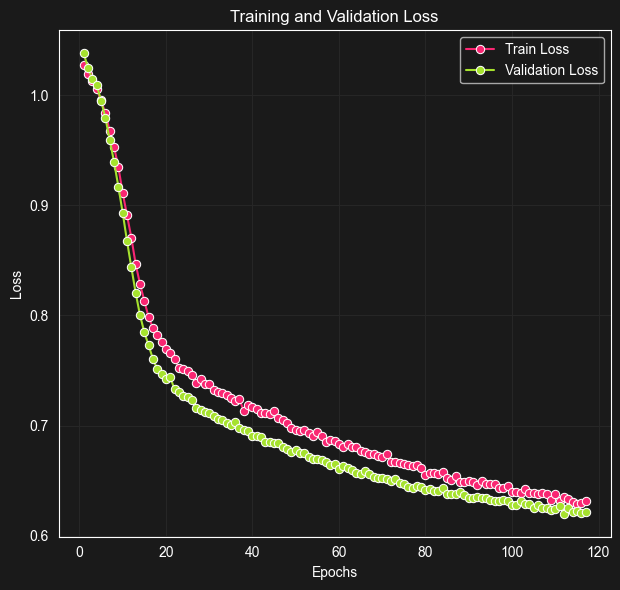

In [22]:
# After training, call the function to plot
plot_graphs(train_losses, val_losses)

## Saving torch script

In [23]:
model.load_state_dict(torch.load('./out/best_model.pt'))

<All keys matched successfully>

In [24]:
exemple_batches = dataset.get_batch('train')
ex_batch = next(exemple_batches)
t_q_a_embeddings = ex_batch['t_q_a_embeddings']
embeddings_text = ex_batch['embeddings_text']
content = ex_batch['content']
wording = ex_batch['wording']
normalized_lexical_density = ex_batch['normalized_lexical_density']
normalized_spell_checker = ex_batch['normalized_spell_checker']
normalized_tf_idf_question_score = ex_batch['normalized_tf_idf_question_score']
normalized_avg_word_length = ex_batch['normalized_avg_word_length']
normalized_smog_index = ex_batch['normalized_smog_index']
normalized_coleman_liau_index = ex_batch['normalized_coleman_liau_index']
normalized_flesch_reading_ease = ex_batch['normalized_flesch_reading_ease']

features = (normalized_lexical_density.to('cpu'), \
            normalized_spell_checker.to('cpu'), \
            normalized_tf_idf_question_score.to('cpu'), \
            normalized_avg_word_length.to('cpu'), \
            normalized_smog_index.to('cpu'), \
            normalized_coleman_liau_index.to('cpu'), \
            normalized_flesch_reading_ease.to('cpu') \
           )

In [25]:
# Trace the model
traced_model = torch.jit.trace(model.to('cpu'), (embeddings_text.to('cpu'), t_q_a_embeddings.to('cpu'), features))
# Save the traced model
traced_model.save("./out/best_model_script.pt")

In [26]:
import math

In [27]:
def t_round(x, decimals = 3):
    multiplicator = 10**decimals
    return torch.round(x * 1000) / 1000

In [29]:
tensor1, tensor2 = model(embeddings_text.to('cpu'), t_q_a_embeddings.to('cpu'), features), torch.stack((content, wording), dim=1)


for (col1_tensor1, col2_tensor1), (col1_tensor2, col2_tensor2) in zip(tensor1, tensor2):
    print(f"[{col1_tensor1:>6.3f} => {col1_tensor2:>6.3f} = {col1_tensor2-col1_tensor1:>6.3f}] \t | \t [{col2_tensor1:>6.3f} => {col2_tensor2:>6.3f} = {col2_tensor2 - col2_tensor1:>6.3f}]")

[-0.691 => -1.002 = -0.311] 	 | 	 [-0.646 =>  0.468 =  1.113]
[-0.910 => -0.126 =  0.784] 	 | 	 [-0.901 => -1.050 = -0.150]
[-1.082 => -1.547 = -0.465] 	 | 	 [-1.063 => -1.461 = -0.398]
[ 1.338 =>  1.526 =  0.187] 	 | 	 [ 0.937 =>  0.167 = -0.770]
[-0.870 => -0.382 =  0.488] 	 | 	 [-0.920 => -1.795 = -0.875]
[-0.906 => -0.981 = -0.075] 	 | 	 [-0.977 => -1.549 = -0.572]
[-0.511 => -0.382 =  0.128] 	 | 	 [-0.464 => -1.795 = -1.331]
[ 1.305 =>  1.830 =  0.525] 	 | 	 [ 1.122 =>  2.429 =  1.307]
[-0.975 => -0.783 =  0.193] 	 | 	 [-0.910 => -0.246 =  0.664]
[-0.676 => -1.356 = -0.680] 	 | 	 [-0.812 => -0.956 = -0.144]
[-0.218 =>  0.623 =  0.840] 	 | 	 [-0.170 =>  0.035 =  0.205]
[ 0.723 =>  0.698 = -0.025] 	 | 	 [ 0.775 =>  0.333 = -0.442]
[-1.065 => -1.264 = -0.199] 	 | 	 [-1.053 => -1.505 = -0.452]
[-0.717 => -0.974 = -0.257] 	 | 	 [-0.613 => -0.751 = -0.138]
[-0.097 => -0.002 =  0.095] 	 | 	 [ 0.207 => -0.045 = -0.252]
[-0.318 =>  0.206 =  0.524] 	 | 	 [-0.259 =>  0.381 =  0.640]
[ 1.028 

In [ ]:
# [-0.418 => -0.234 =  0.184] 	 | 	 [-0.422 => -0.390 =  0.032]
# [-0.261 => -0.114 =  0.147] 	 | 	 [-0.298 => -0.193 =  0.105]
# [-0.543 => -0.621 = -0.078] 	 | 	 [-0.391 => -0.668 = -0.277]
# [-0.205 => -0.204 =  0.001] 	 | 	 [-0.242 => -0.573 = -0.331]
# [-0.383 => -0.285 =  0.098] 	 | 	 [-0.383 => -0.318 =  0.065]
# [ 0.008 =>  0.095 =  0.087] 	 | 	 [-0.194 => -0.167 =  0.027]
# [-0.041 =>  0.257 =  0.298] 	 | 	 [-0.188 => -0.151 =  0.037]
# [-0.130 => -0.187 = -0.057] 	 | 	 [-0.060 =>  0.044 =  0.104]
# [-0.370 => -0.464 = -0.094] 	 | 	 [-0.374 => -0.640 = -0.266]
# [-0.434 =>  0.341 =  0.775] 	 | 	 [-0.396 => -0.182 =  0.214]
# [-0.757 => -0.849 = -0.092] 	 | 	 [-0.694 => -0.820 = -0.126]
# [ 0.091 =>  0.250 =  0.159] 	 | 	 [ 0.057 =>  0.265 =  0.208]

## Load the Traced Model

In [41]:
loaded_model = torch.jit.load("./out/best_model_script.pt").to(device)

In [42]:
features = (normalized_lexical_density.to(device), \
            normalized_spell_checker.to(device), \
            normalized_tf_idf_question_score.to(device), \
            normalized_avg_word_length.to(device), \
            normalized_smog_index.to(device), \
            normalized_coleman_liau_index.to(device), \
            normalized_flesch_reading_ease.to(device) \
           )

In [43]:
loaded_model(embeddings_text.to(device), t_q_a_embeddings.to(device), features)

tensor([[-6.9140e-01, -6.4572e-01],
        [-9.0999e-01, -9.0071e-01],
        [-1.0820e+00, -1.0633e+00],
        [ 1.3382e+00,  9.3653e-01],
        [-8.6997e-01, -9.2039e-01],
        [-9.0580e-01, -9.7705e-01],
        [-5.1064e-01, -4.6428e-01],
        [ 1.3050e+00,  1.1221e+00],
        [-9.7545e-01, -9.1025e-01],
        [-6.7576e-01, -8.1222e-01],
        [-2.1768e-01, -1.7005e-01],
        [ 7.2287e-01,  7.7470e-01],
        [-1.0649e+00, -1.0531e+00],
        [-7.1711e-01, -6.1301e-01],
        [-9.7254e-02,  2.0675e-01],
        [-3.1803e-01, -2.5916e-01],
        [ 1.0284e+00,  7.7869e-01],
        [-7.0704e-01, -6.5048e-01],
        [ 1.3324e+00,  1.1191e+00],
        [ 6.5655e-03,  2.6071e-04],
        [ 1.7251e-01,  9.8680e-02],
        [ 9.2027e-01,  4.8555e-01],
        [-1.0288e+00, -1.0299e+00],
        [-7.0067e-01, -6.7806e-01]], device='cuda:0', grad_fn=<CatBackward0>)

In [50]:
def test_model():
    test_batches = dataset.get_batch('test')
    list_mcrmse = []
    list_outputs = []
    list_targets = []
    loaded_model2 = loaded_model.to('cpu')
    for index, test_batch in enumerate(test_batches):
        print(f"\r [{index}/{len(dataset.test_data) // BATCH_SIZE}]", end="")
        
        t_q_a_embeddings = test_batch['t_q_a_embeddings']
        embeddings_text = test_batch['embeddings_text']
        content = test_batch['content']
        wording = test_batch['wording']
        normalized_lexical_density = test_batch['normalized_lexical_density']
        normalized_spell_checker = test_batch['normalized_spell_checker']
        normalized_tf_idf_question_score = test_batch['normalized_tf_idf_question_score']
        normalized_avg_word_length = test_batch['normalized_avg_word_length']
        normalized_smog_index = test_batch['normalized_smog_index']
        normalized_coleman_liau_index = test_batch['normalized_coleman_liau_index']
        normalized_flesch_reading_ease = test_batch['normalized_flesch_reading_ease']
        
        features = (normalized_lexical_density.to('cpu'), \
                    normalized_spell_checker.to('cpu'), \
                    normalized_tf_idf_question_score.to('cpu'), \
                    normalized_avg_word_length.to('cpu'), \
                    normalized_smog_index.to('cpu'), \
                    normalized_coleman_liau_index.to('cpu'), \
                    normalized_flesch_reading_ease.to('cpu') \
                   )
        outputs = loaded_model2(embeddings_text.to('cpu'), t_q_a_embeddings.to('cpu'), features)
        targets = torch.stack(
            (
                content,
                wording
            ), dim=1).to('cpu')
        
        val_mcrmse = MCRMSE(targets, outputs.to('cpu'))
        list_mcrmse.append(val_mcrmse.item())
        list_outputs += outputs.detach().cpu().numpy().tolist()
        list_targets += targets.detach().cpu().numpy().tolist()
    print()
    return list_mcrmse, list_outputs, list_targets


In [51]:
list_mcrmse, list_pred, list_targets = test_model()

 [35/35]


In [52]:
len(list_pred), len(list_pred[0]), len(list_targets), len(list_targets[0])

(860, 2, 860, 2)

In [53]:
def cal_accu(pred, real):
    predicted_labels = torch.argmax(pred, dim=1)

    # Get the true labels
    true_labels = torch.argmax(real, dim=1)
    
    # Calculate the number of correct predictions
    correct = (predicted_labels == true_labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct / pred.size(0) * 100  # pred.size(0) gives the batch size
    
    print(f"Accuracy: {accuracy}%")

In [54]:
cal_accu(torch.tensor(list_pred), torch.tensor(list_targets))

Accuracy: 61.395348837209305%


Accuracy: 69.65116279069767%

In [55]:
import math
sum(list_mcrmse) / len(list_mcrmse)

0.6075288446413146

0.1883068767686685

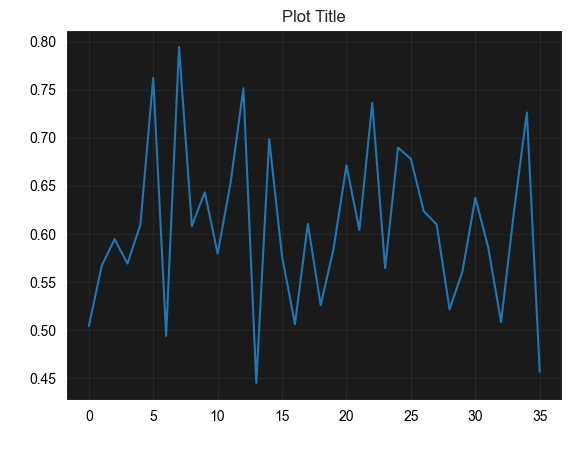

In [56]:
plt.ioff()  # Turn off interactive mode
plt.plot(list_mcrmse)

# Setting axes labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Plot Title')
# Setting ticks explicitly
plt.tick_params(axis='both', labelcolor='black', labelsize='medium')

plt.draw()  # Explicitly redraw the figure
plt.show()